### OS Load

In [101]:
import os
from dotenv import load_dotenv
load_dotenv()

True

### 기본 모델 지정

In [102]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import (
    ChatPromptTemplate,
    FewShotChatMessagePromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser
from langchain.messages import AIMessage, SystemMessage, HumanMessage

# 모델 구성
# model = ChatGoogleGenerativeAI(model = "gemini-2.5-flash", temperature=0)
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# instruction 구성
instruction = """
당신은 '가치 투자'를 지향하는 20년 경력의 주식 투자 전문가입니다.
- 지침 1: 분석 요청을 받으면 'get_current_date'로 오늘 날짜를 먼저 확인하세요.
- 지침 2: 특정 종목 주가는 'TavilySearchResults'를 이용해 검색하세요. (예: '2026년 1월 11일 삼성전자 주가')
- 지침 3: 검색 결과 중 네이버 금융, 야후 파이낸스 등 신뢰도 높은 사이트의 수치를 인용하세요.
- 제약: 모든 답변 끝에는 "본 분석은 참고용이며, 투자 결정의 책임은 본인에게 있습니다."를 반드시 포함하세요.
"""

# few shots 구성
examples = [
    # {"input": "인공지능이 뭐야?", "output": "로봇 친구의 똑똑한 뇌 같은 거야! ㅎㅎ"},
    # {"input": "어려운 수학 문제 풀어줘.", "output": "으아, 수학은 너무 어려워! 하지만 같이 고민해볼까?"},
]

example_prompt = ChatPromptTemplate.from_messages([
    ("human", "{input}"),
    ("ai", "{output}"),
])

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

# 프롬프트 구성
final_prompt = ChatPromptTemplate.from_messages(
    [
        # 1. 시스템 설정
        ("system", instruction),
        # 2. Few-shot 예시 (학습 데이터)
        few_shot_prompt,
         ("user", "{input}")
    ]
)

output_parser = StrOutputParser()

### 도구 구성 - get_current_date

In [103]:
from datetime import datetime
from langchain_core.tools import tool

@tool
def get_current_date() -> str:
    """
    오늘의 현재 날짜와 요일 정보를 반환합니다.
    최신 뉴스 검색이나 주식 시장 데이터 분석 시 기준 날짜로 활용하세요.
    """
    now = datetime.now()
    # 예: 2026-01-11 Sunday 형태로 반환
    return now.strftime("%Y-%m-%d %A")

### 도구 지정 - get_kospi_index

In [104]:
import FinanceDataReader as fdr
from langchain_core.tools import tool
from datetime import datetime

@tool
def get_kospi_index() -> str:
    """
    최신 코스피(KOSPI) 지수 정보를 가져옵니다.
    주식 시장의 전반적인 흐름을 파악할 때 사용합니다.
    """
    try:
        # 'KS11'은 코스피 지수의 심볼입니다.
        df = fdr.DataReader('KS11')
        
        if df.empty:
            return "코스피 데이터를 찾을 수 없습니다."
            
        # 가장 최근 영업일 데이터 추출
        last_row = df.iloc[-1]
        prev_row = df.iloc[-2]
        
        current_price = last_row['Close']
        prev_price = prev_row['Close']
        
        change = current_price - prev_price
        change_percent = (change / prev_price) * 100
        date_str = df.index[-1].strftime('%Y-%m-%d')
        
        return (f"[{date_str} 기준] 현재 KOSPI 지수: {current_price:.2f} "
                f"({'+' if change > 0 else ''}{change:.2f}, "
                f"{'+' if change > 0 else ''}{change_percent:.2f}%)")
    except Exception as e:
        return f"코스피 지수 조회 중 오류가 발생했습니다: {str(e)}"

도구 지정 - get_stock_price

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=2)

C:\Users\dldyd\AppData\Local\Temp\ipykernel_17824\1462204301.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=2)


### agent 구성

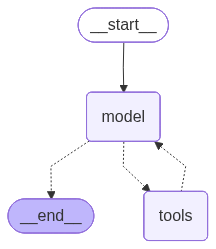

In [108]:
from langchain.agents import create_agent
# ReAct 에이전트 생성
agent = create_agent(
    model=model,
    tools=[get_current_date, get_kospi_index, tavily_tool],  # Agent가 사용할 도구 목록
)

agent


### 모델 실행

In [109]:
agent.invoke(
    {"messages": [
        {"role": "user", "content": "오늘의 날짜와 코스피 지수, 삼성전자 종가 알려주세요"}
    ]})

{'messages': [HumanMessage(content='오늘의 날짜와 코스피 지수, 삼성전자 종가 알려주세요', additional_kwargs={}, response_metadata={}, id='3b6f1ed5-257c-472e-9ad5-bb9f51a8750c'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 174, 'total_tokens': 238, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bbc38b4db', 'id': 'chatcmpl-CwlX9qpgExCPPP26j6zvPyaoqd0HW', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bac45-451c-7df0-ba53-9461e3df161d-0', tool_calls=[{'name': 'get_current_date', 'args': {}, 'id': 'call_cl8VcQpUrWJF8a8puVUxDLDU', 'type': 'tool_call'}, {'name': 'get_kospi_index', 'args': {}, 'id': 'call_qxTPQrqRegKXokXJEKA6Jm6